Lets process the data for the experiment

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import os
import glob

# Funktion zum Laden der Hidden States und Labels aus npy Dateien
def load_hidden_states_and_labels(root_dir, speakers, layer, max_files_per_speaker=50):
    all_hidden_states = []
    all_labels = []
    
    for speaker in tqdm(speakers):
        layer_path = os.path.join(root_dir, speaker, f'layer_{layer}')
        file_paths = glob.glob(os.path.join(layer_path, '*.npy'))[:max_files_per_speaker]
        for file_path in file_paths:
            hidden_states = np.load(file_path)
            if hidden_states.shape[2] == 1024:  # Überprüfen der Dimensionen
                hidden_states = hidden_states.reshape(-1, 1024)  # Umformung zu (n, 1024)
                all_hidden_states.append(hidden_states)
                labels = np.array([speaker] * hidden_states.shape[0]) # Erstellung der Labels für jeden Hidden State
                all_labels.append(labels)
    
    combined_hidden_states = np.vstack(all_hidden_states)
    combined_labels = np.hstack(all_labels)
    
    return combined_hidden_states, combined_labels

# Beispielhafte Sprecher und Anzahl der Layer
root_dir = 'data/all_speakers_w2vec_28.05'  # Anpassung notwendig
speakers = ['speaker_' + str(i) for i in range(1, 21)]
num_layers = 25  # Beispielhafte Anzahl von Layern

hidden_states = []
labels = []
Ys = []

encoder = OneHotEncoder(sparse_output=False)

for i in range(18, num_layers):
    print(f"Processing layer {i}")
    hidden_states_layer, labels_layer = load_hidden_states_and_labels(root_dir, speakers, i)
    hidden_states.append(hidden_states_layer)
    labels.append(labels_layer)
    Ys.append(encoder.fit_transform(labels_layer.reshape(-1, 1)))

Computing the SVCCA Score for the different hidden layers

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import os
import glob
from SVCCA import SVCCA

np.random.seed(42)

def aggregate_vectors(vectors, method='mean'):
    if method == 'mean':
        return np.mean(vectors, axis=0)
    elif method == 'median':
        return np.median(vectors, axis=0)
    elif method == 'max':
        return np.max(vectors, axis=0)
    elif method == 'min':
        return np.min(vectors, axis=0)
    else:
        raise ValueError(f"Unsupported aggregation method: {method}")

# Funktion zum Laden der Hidden States und Labels aus npy Dateien
def load_hidden_states_and_labels(root_dir, speakers, layer, aggregation_method='mean', max_files_per_speaker=50):
    all_hidden_states = []
    all_labels = []
    
    for speaker in tqdm(speakers):
        layer_path = os.path.join(root_dir, speaker, f'layer_{layer}')
        file_paths = glob.glob(os.path.join(layer_path, '*.npy'))[:max_files_per_speaker]
        for file_path in file_paths:
            hidden_states = np.load(file_path)
            if hidden_states.ndim == 3 and hidden_states.shape[2] == 1024:  # Überprüfen der Dimensionen
                hidden_states = hidden_states.reshape(-1, 1024)  # Umformung zu (n, 1024)
            elif hidden_states.ndim == 2 and hidden_states.shape[1] == 1280:  # Für die Form (1, 1280)
                hidden_states = hidden_states.reshape(-1, 1280)  # Umformung zu (n, 1280)
            else:
                print(f"Unexpected shape {hidden_states.shape} in file {file_path}")
                continue
            pooled_hidden_states = aggregate_vectors(hidden_states, method=aggregation_method)
            all_hidden_states.append(pooled_hidden_states)
            labels = np.array([speaker] * 1)  # Erstellung eines Labels für den gepoolten Hidden State
            all_labels.append(labels)

    combined_hidden_states = np.vstack(all_hidden_states)
    combined_labels = np.hstack(all_labels)
    
    # Daten shufflen
    indices = np.arange(combined_hidden_states.shape[0])
    np.random.shuffle(indices)
    combined_hidden_states = combined_hidden_states[indices]
    combined_labels = combined_labels[indices]
    
    return combined_hidden_states, combined_labels

# Beispielhafte Sprecher und Anzahl der Layer
root_dir = '/home/rag/experimental_trial/data/all_speakers_wav2vec_finetuned'  # Anpassung notwendig
speakers = ['speaker_' + str(i) for i in range(1, 51)]
num_layers = 25  # Beispielhafte Anzahl von Layern

results = []

encoder = OneHotEncoder(sparse_output=False)

for i in range(num_layers):
    print(f"Processing layer {i}")
    hidden_states_layer, labels_layer = load_hidden_states_and_labels(root_dir, speakers, i)
    
    # One-Hot-Encoding der Labels
    Ys = encoder.fit_transform(labels_layer.reshape(-1, 1))
    
    # SVCCA ausführen
    svcca = SVCCA(hidden_states=[hidden_states_layer], labels=[Ys], use_gpu=True)
    svcca.calculate_max_correlations() 
    
    # Zwischenspeicherung der Ergebnisse
    max_corr = svcca.max_correlations[0] 
    results.append({'layer': i, 'max_correlation': max_corr})

# Ergebnisse in eine CSV-Datei speichern
results_df = pd.DataFrame(results)
results_df.to_csv('results/svcca_gpu/svcca_results_50_w2v_ft.csv', index=False)
print("Ergebnisse erfolgreich in 'results/svcca_gpu/svcca_results_50_w2v_ft.csv' gespeichert.")

Computing adjusted rand score, normalized mutual info score and and sihouette score layerwise

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import os
import glob
from joblib import Parallel, delayed

def aggregate_vectors(vectors, method='mean'):
    if method == 'mean':
        return np.mean(vectors, axis=0)
    elif method == 'median':
        return np.median(vectors, axis=0)
    elif method == 'max':
        return np.max(vectors, axis=0)
    elif method == 'min':
        return np.min(vectors, axis=0)
    else:
        raise ValueError(f"Unsupported aggregation method: {method}")

def load_and_aggregate_data(root_dir, speakers, layer, aggregation_method='mean', max_files_per_speaker=50):
    aggregated_vectors = []
    labels = []
    speaker_to_label = {speaker: idx for idx, speaker in enumerate(speakers)}

    def process_file(file_path):
        hidden_states = np.load(file_path).squeeze(0)
        aggregated_vector = aggregate_vectors(hidden_states, method=aggregation_method)
        return aggregated_vector

    def process_speaker(speaker):
        speaker_vectors = []
        layer_path = os.path.join(root_dir, speaker, f'layer_{layer}')
        file_paths = glob.glob(os.path.join(layer_path, '*.npy'))[:max_files_per_speaker]
        for file_path in file_paths:
            speaker_vectors.append(process_file(file_path))
        return speaker_vectors, [speaker_to_label[speaker]] * len(speaker_vectors)

    results = Parallel(n_jobs=-1, backend="threading")(delayed(process_speaker)(speaker) for speaker in tqdm(speakers))
    
    for agg_vectors, labels_list in results:
        aggregated_vectors.extend(agg_vectors)
        labels.extend(labels_list)

    return np.array(aggregated_vectors), np.array(labels)

# Assuming root directory and speakers list are correctly specified
root_dir = '/home/rag/experimental_trial/data/all_speakers_xlrs_finetuned'  # Update with your actual directory path
speakers = ['speaker_' + str(i) for i in range(1, 51)]
aggregation_method = 'mean'  # Change to 'median', 'max', or 'min' if desired
num_layers = 24  # Define the number of layers

# Initialize the CSV file with headers
results_df = pd.DataFrame(columns=['Layer', 'Adjusted Rand Index', 'Normalized Mutual Information', 'Silhouette Score'])
results_df.to_csv('results/clustering_results_50_speakers_xls_finetuned.csv', mode='w', header=True, index=False)

for i in range(num_layers + 1):
    print(f"Processing layer {i}")
    aggregated_vectors, labels = load_and_aggregate_data(root_dir, speakers, i, aggregation_method=aggregation_method)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(aggregated_vectors)

    # Clustering
    kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calculate clustering metrics
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    ari = adjusted_rand_score(labels, cluster_labels)
    nmi = normalized_mutual_info_score(labels, cluster_labels)

    print(f"Layer {i}: Adjusted Rand Index = {ari}, Normalized Mutual Information = {nmi}, Silhouette Score = {silhouette_avg}")

    # Append results to CSV
    results_df = pd.DataFrame({'Layer': [i], 'Adjusted Rand Index': [ari], 'Normalized Mutual Information': [nmi], 'Silhouette Score': [silhouette_avg]})
    results_df.to_csv('results/clustering_results_50_speakers_xls_finetuned.csv', mode='a', header=False, index=False)


Plotting clustering scores

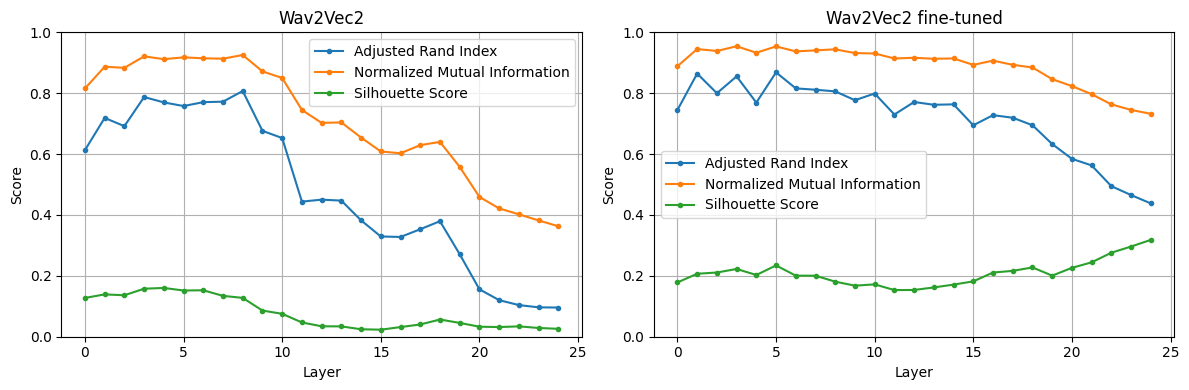

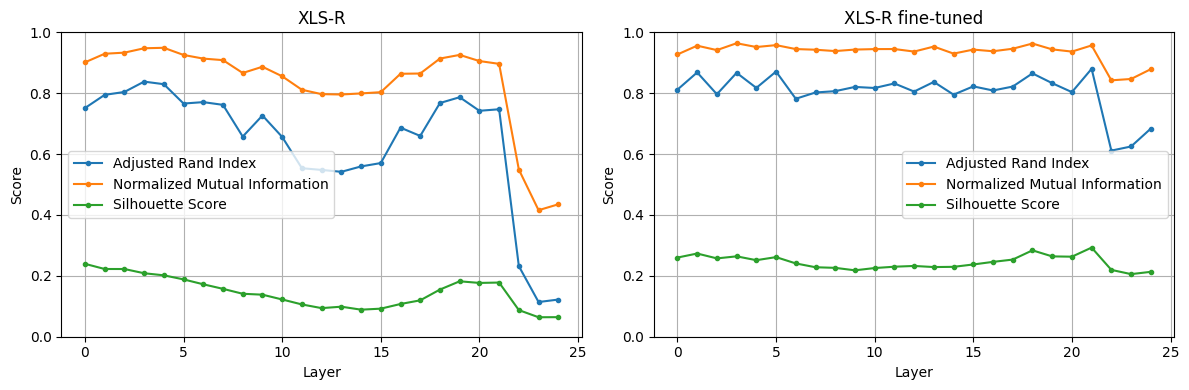

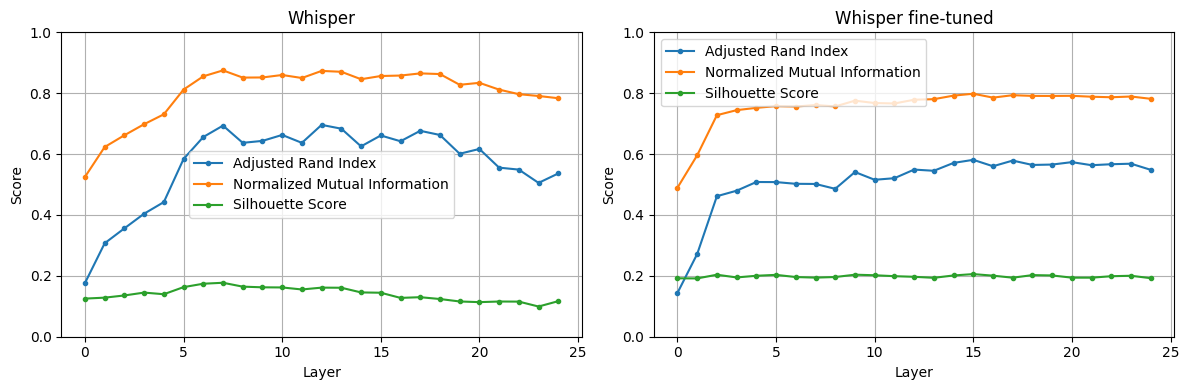

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lesen Sie die CSV-Dateien ein
results_df = pd.read_csv('results/clustering_results_50_speakers.csv')
results_finetuned_df = pd.read_csv('results/clustering_results_50_speakers_wav2vec_ft.csv')
results_whisper_df = pd.read_csv('results/clustering_results_50_speakers_whisper.csv')
results_whisper_finetuned_df = pd.read_csv('results/clustering_results_50_speakers_whisper_finetuned.csv')
results_xls_r_df = pd.read_csv('results/clustering_results_50_speakers_xls_r_300m.csv')
results_xls_r_finetuned_df = pd.read_csv('results/clustering_results_50_speakers_xls_finetuned.csv')

# Plot für Wav2Vec2 und Wav2Vec2 fine-tuned
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(results_df['Layer'], results_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[0].plot(results_df['Layer'], results_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[0].plot(results_df['Layer'], results_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Score')
axes[0].set_title('Wav2Vec2')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, 1)

axes[1].plot(results_finetuned_df['Layer'], results_finetuned_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[1].plot(results_finetuned_df['Layer'], results_finetuned_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[1].plot(results_finetuned_df['Layer'], results_finetuned_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Score')
axes[1].set_title('Wav2Vec2 fine-tuned')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot für XLS-R und XLS-R fine-tuned
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(results_xls_r_df['Layer'], results_xls_r_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[0].plot(results_xls_r_df['Layer'], results_xls_r_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[0].plot(results_xls_r_df['Layer'], results_xls_r_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Score')
axes[0].set_title('XLS-R')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, 1)

axes[1].plot(results_xls_r_finetuned_df['Layer'], results_xls_r_finetuned_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[1].plot(results_xls_r_finetuned_df['Layer'], results_xls_r_finetuned_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[1].plot(results_xls_r_finetuned_df['Layer'], results_xls_r_finetuned_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Score')
axes[1].set_title('XLS-R fine-tuned')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot für Whisper und Whisper fine-tuned
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(results_whisper_df['Layer'], results_whisper_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[0].plot(results_whisper_df['Layer'], results_whisper_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[0].plot(results_whisper_df['Layer'], results_whisper_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Score')
axes[0].set_title('Whisper')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, 1)

axes[1].plot(results_whisper_finetuned_df['Layer'], results_whisper_finetuned_df['Adjusted Rand Index'], marker='.', label='Adjusted Rand Index')
axes[1].plot(results_whisper_finetuned_df['Layer'], results_whisper_finetuned_df['Normalized Mutual Information'], marker='.', label='Normalized Mutual Information')
axes[1].plot(results_whisper_finetuned_df['Layer'], results_whisper_finetuned_df['Silhouette Score'], marker='.', label='Silhouette Score')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Score')
axes[1].set_title('Whisper fine-tuned')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


T-SNE

Processing layer 0


100%|██████████| 10/10 [00:00<00:00, 38444.58it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 12.085667
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.259460
[t-SNE] KL divergence after 1000 iterations: 0.377836
Processing layer 5


100%|██████████| 10/10 [00:00<00:00, 38095.40it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 12.134716
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.166180
[t-SNE] KL divergence after 1000 iterations: 0.253527
Processing layer 10


100%|██████████| 10/10 [00:00<00:00, 26596.73it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 11.467758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.643051
[t-SNE] KL divergence after 1000 iterations: 0.448949
Processing layer 15


100%|██████████| 10/10 [00:00<00:00, 34155.57it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 10.421411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.522129
[t-SNE] KL divergence after 1000 iterations: 0.712714
Processing layer 20


100%|██████████| 10/10 [00:00<00:00, 33261.73it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.002s...
[t-SNE] Computed neighbors for 500 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 9.874296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.973965
[t-SNE] KL divergence after 1000 iterations: 0.738873
Processing layer 24


100%|██████████| 10/10 [00:00<00:00, 16797.37it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 8.832316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.379456
[t-SNE] KL divergence after 1000 iterations: 1.059117


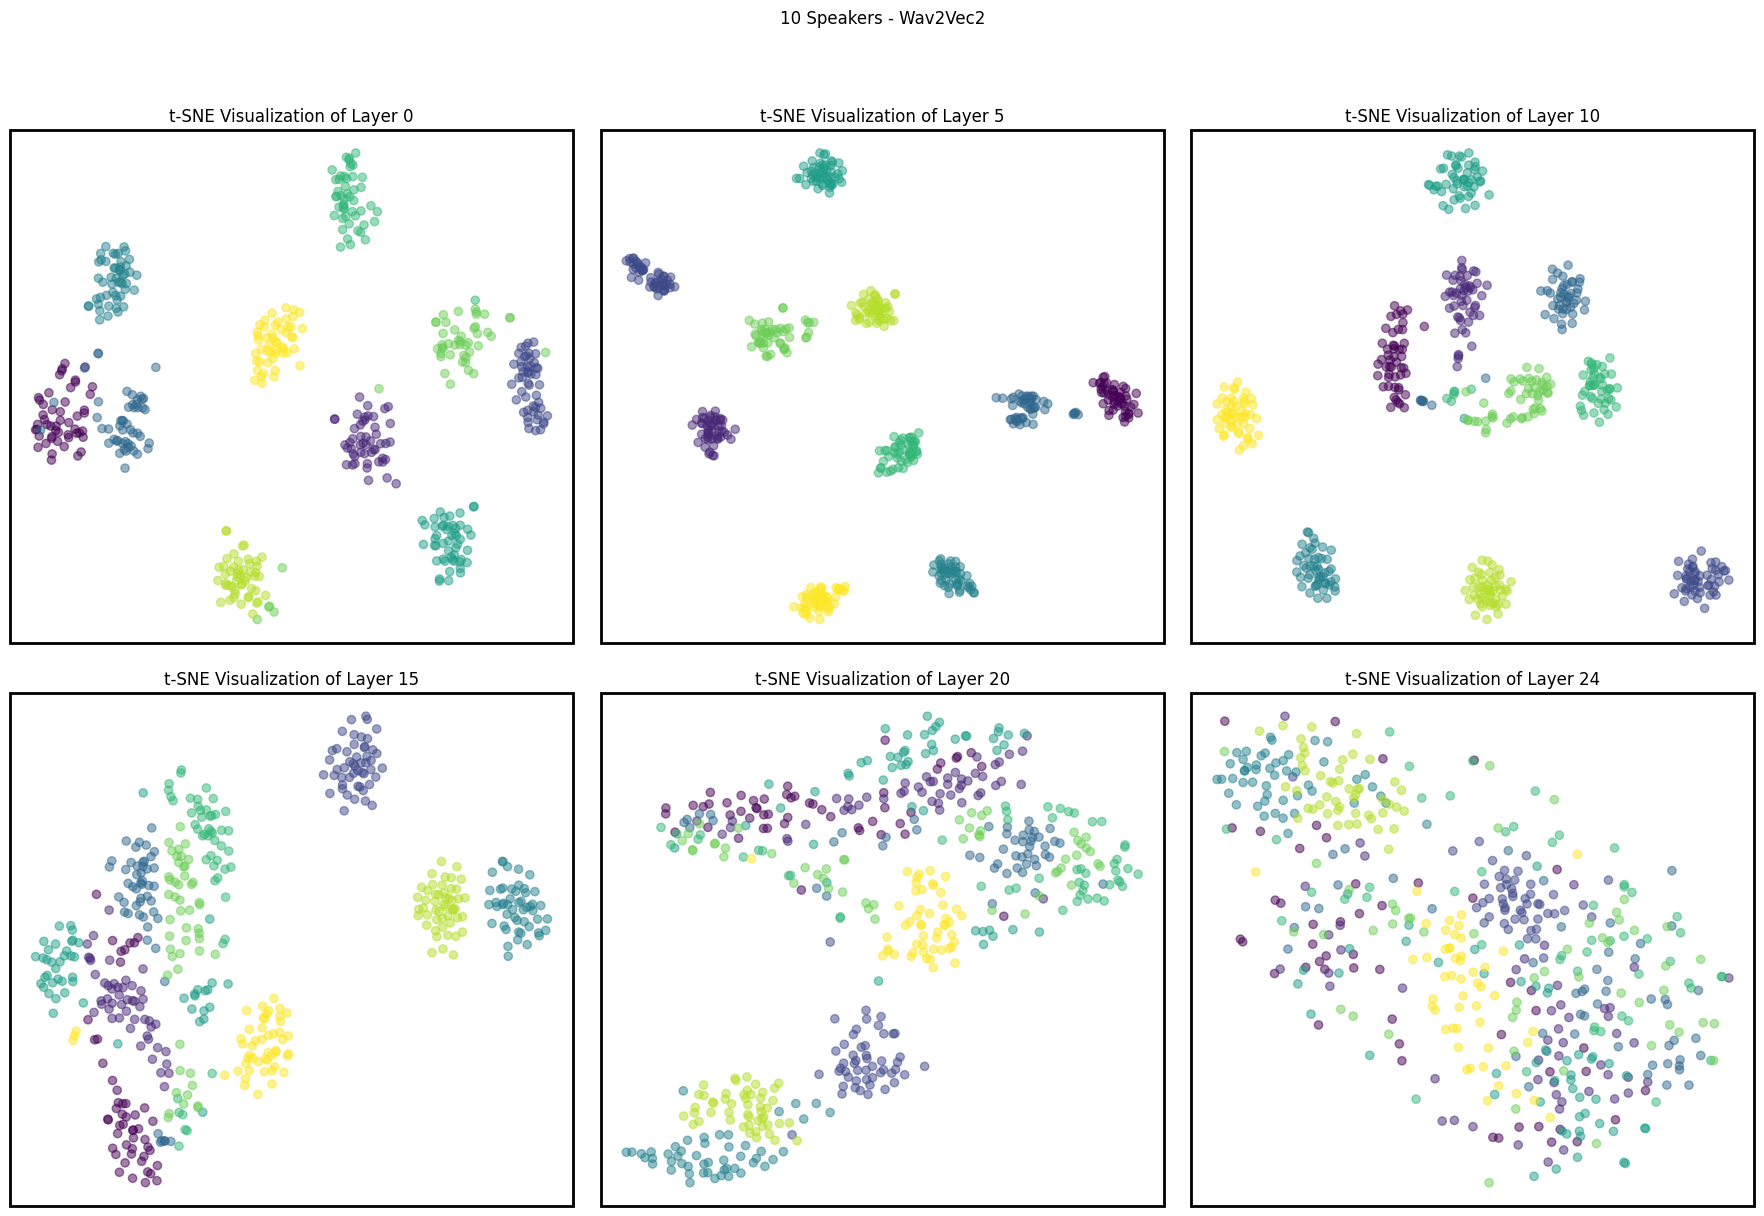

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import glob
from joblib import Parallel, delayed

def aggregate_vectors(vectors, method='mean'):
    if method == 'mean':
        return np.mean(vectors, axis=0)
    elif method == 'median':
        return np.median(vectors, axis=0)
    elif method == 'max':
        return np.max(vectors, axis=0)
    elif method == 'min':
        return np.min(vectors, axis=0)
    else:
        raise ValueError(f"Unsupported aggregation method: {method}")

def load_and_aggregate_data(root_dir, speakers, layer, aggregation_method='mean', max_files_per_speaker=50):
    aggregated_vectors = []
    labels = []
    speaker_to_label = {speaker: idx for idx, speaker in enumerate(speakers)}

    def process_file(file_path):
        hidden_states = np.load(file_path).squeeze(0)
        aggregated_vector = aggregate_vectors(hidden_states, method=aggregation_method)
        return aggregated_vector

    def process_speaker(speaker):
        speaker_vectors = []
        layer_path = os.path.join(root_dir, speaker, f'layer_{layer}')
        file_paths = glob.glob(os.path.join(layer_path, '*.npy'))[:max_files_per_speaker]
        for file_path in file_paths:
            speaker_vectors.append(process_file(file_path))
        return speaker_vectors, [speaker_to_label[speaker]] * len(speaker_vectors)

    results = Parallel(n_jobs=-1, backend="threading")(delayed(process_speaker)(speaker) for speaker in tqdm(speakers))
    
    for agg_vectors, labels_list in results:
        aggregated_vectors.extend(agg_vectors)
        labels.extend(labels_list)

    return np.array(aggregated_vectors), np.array(labels)

# Assuming root directory and speakers list are correctly specified
root_dir = '/home/rag/experimental_trial/data/all_speakers_w2vec_28.05'  # Update with your actual directory path
speakers = ['speaker_' + str(i) for i in range(1, 11)]
aggregation_method = 'mean'  # Change to 'median', 'max', or 'min' if desired
layers = [0, 5, 10, 15, 20, 24]  # Example layers

# Prepare the plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    print(f"Processing layer {layer}")
    aggregated_vectors, labels = load_and_aggregate_data(root_dir, speakers, layer, aggregation_method=aggregation_method)
    
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(aggregated_vectors)

    # Clustering
    kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    tsne_results = tsne.fit_transform(X_scaled)

    # Visualization
    scatter = axes[idx].scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)
    axes[idx].set_title(f't-SNE Visualization of Layer {layer}')
    # no ticks
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

    # Add a border around each plot
    axes[idx].set_frame_on(True)
    axes[idx].patch.set_edgecolor('black')
    axes[idx].patch.set_linewidth(2)

# Create a single discrete colorbar
#cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
#cbar.set_label('Speaker Labels')
#cbar.set_ticks(np.arange(len(speakers)))
#cbar.set_ticklabels(['Speaker_' + str(i) for i in range(1, len(speakers) + 1)])

plt.suptitle('10 Speakers - Wav2Vec2', y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

Plotting SVCCA

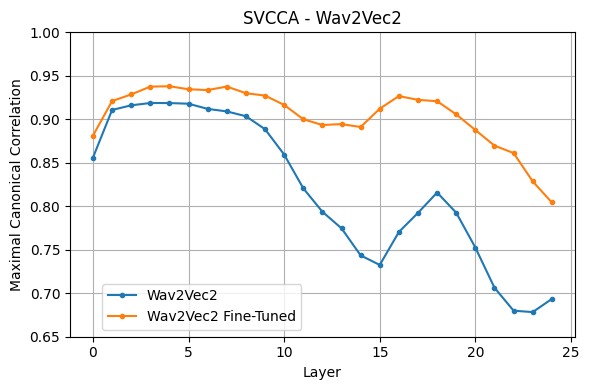

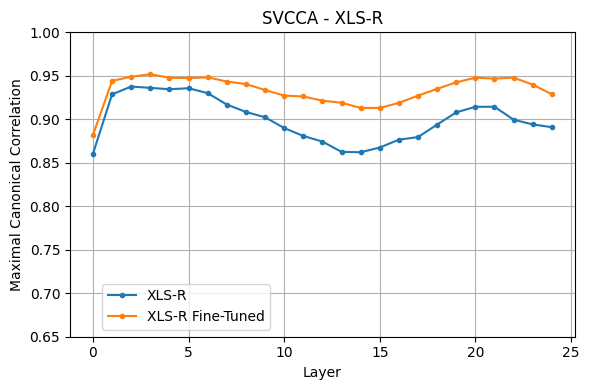

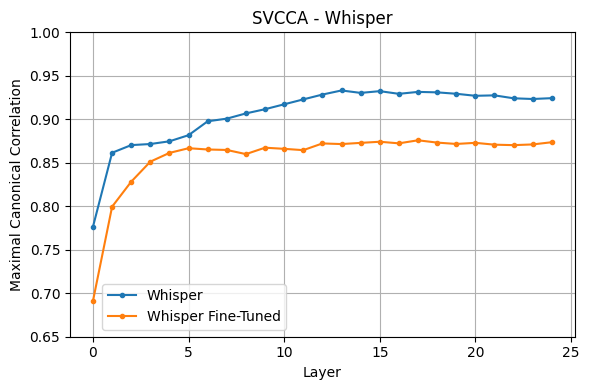

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
w2v = pd.read_csv('results/svcca_gpu/svcca_results_50_w2v.csv')['max_correlation']
w2v_finetuned = pd.read_csv('results/svcca_gpu/svcca_results_50_w2v_ft.csv')['max_correlation']
xlsr = pd.read_csv('results/svcca_gpu/svcca_results_50_xlsr.csv')['max_correlation']
xlsr_finetuned = pd.read_csv('results/svcca_gpu/svcca_results_50_xlsr_ft.csv')['max_correlation']
whisper = pd.read_csv('results/svcca_gpu/svcca_results_50_whisper.csv')['max_correlation']
whisper_finetuned = pd.read_csv('results/svcca_gpu/svcca_results_50_whisper_ft.csv')['max_correlation']

# Plot for Wav2Vec2
plt.figure(figsize=(6, 4))
plt.plot(w2v, label='Wav2Vec2', marker='.')
plt.plot(w2v_finetuned, label='Wav2Vec2 Fine-Tuned', marker='.')
plt.title('SVCCA - Wav2Vec2')
plt.xlabel('Layer')
plt.ylabel('Maximal Canonical Correlation')
plt.legend(loc='lower left', bbox_to_anchor=(0.05, 0))
plt.grid()
plt.ylim(0.65, 1)
plt.tight_layout()
plt.show()

# Plot for XLS-R
plt.figure(figsize=(6, 4))
plt.plot(xlsr, label='XLS-R', marker='.')
plt.plot(xlsr_finetuned, label='XLS-R Fine-Tuned', marker='.')
plt.title('SVCCA - XLS-R')
plt.xlabel('Layer')
plt.ylabel('Maximal Canonical Correlation')
plt.legend(loc='lower left', bbox_to_anchor=(0.05, 0))
plt.grid()
plt.ylim(0.65, 1)
plt.tight_layout()
plt.show()

# Plot for Whisper
plt.figure(figsize=(6, 4))
plt.plot(whisper, label='Whisper', marker='.')
plt.plot(whisper_finetuned, label='Whisper Fine-Tuned', marker='.')
plt.title('SVCCA - Whisper')
plt.xlabel('Layer')
plt.ylabel('Maximal Canonical Correlation')
plt.legend(loc='lower left', bbox_to_anchor=(0.05, 0))
plt.grid()
plt.ylim(0.65, 1)
plt.tight_layout()
plt.show()
